In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_string_dtype, is_numeric_dtype

In [9]:
from google.colab import files
data_to_load = files.upload()

In [210]:
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
transactions = pd.read_csv("transactions.csv")

## Observations des tables :

In [211]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [212]:
products.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [213]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


## Tests sur la table customers

In [214]:
customers.isna().sum()
customers.duplicated().sum()

#On supprime les client_id test en ne gardant que les id commençant par "c_"
customers = customers.loc[customers["client_id"].str.startswith("c_")]

#On teste l'unicité de la clé primaire de la table
customers["client_id"].nunique() == customers.shape[0]

True

## Tests sur la table products

In [215]:
products.isna().sum()
products.duplicated().sum()

#On supprime les id_prod test en ne gardant que les id ne commençant pas par "T"
products = products.loc[~products["id_prod"].str.startswith("T_")]

#On teste l'unicité de la clé primaire de la table
print(products["id_prod"].nunique() == products.shape[0])

#On regarde si tous les prix sont strictement positifs
print((products["price"] <= 0).sum() )

#On regarde si le premier chiffre de id_prod correspond à la catégorie du produit
print((products["id_prod"].str[0] == products["categ"].astype(str)).sum())



True
0
3286


## Tests sur la table transactions

In [216]:
#On retire les transactions test qui ont le session_id s_0
transactions = transactions.loc[transactions["session_id"] != "s_0"]

transactions.isna().sum()
transactions.duplicated().sum()

#On teste l'unicité de la clé primaire de la table
transactions["date"].nunique() == transactions.shape[0]



True

In [217]:
#On regarde les id_prod de la table products non présents dans transactions
#[x for x in products['id_prod'].unique() if not x in transactions['id_prod'].unique()]

In [218]:
#On regarde les id_prod de la table transactions non présents dans products
#[x for x in transactions['id_prod'].unique() if not x in products['id_prod'].unique()]

In [219]:
#On regarde les client_id de la table transactions non présents dans customers
#[x for x in transactions['client_id'].unique() if not x in customers['client_id'].unique()]

In [220]:
#on calcule le prix moyen des livres de la catégorie 0 car le livre manquant a un id_prod commençant par 0 pour remplir les infos manquantes (prix et catégorie) après la jointure dans les 221 transactions concernées par ce livre.

prix_moyen_0 = products[products["categ"] == 0]["price"].mean()
print(prix_moyen_0)
transactions.loc[transactions["id_prod"] == "0_2245"]

11.732794627383296


,id_prod,date,session_id,client_id
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954
...,...,...,...,...
669730,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131
670682,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167
671286,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453
675679,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098


In [221]:
#On fait notre jointure en prennant comme point de départ la table "transactions" à laquelle on vient rattacher les 2 autres tables par des jointures left successives.
#On convertit également la colonne date au format datetime pour l'utiliser comme index.
joint1 = pd.merge(transactions, customers, on="client_id", how="left",)
full_table = pd.merge(joint1, products, on="id_prod", how="left")
full_table['date'] = pd.to_datetime(full_table['date'])
full_table = full_table.set_index('date')
full_table.head()

,id_prod,session_id,client_id,sex,birth,price,categ
date,,,,,,,
2022-05-20 13:21:29.043970,0_1518,s_211425,c_103,f,1986,4.18,0.0
2022-02-02 07:55:19.149409,1_251,s_158752,c_8534,m,1988,15.99,1.0
2022-06-18 15:44:33.155329,0_1277,s_225667,c_6714,f,1968,7.99,0.0
2021-06-24 04:19:29.835891,2_209,s_52962,c_6941,m,2000,69.99,2.0
2023-01-11 08:22:08.194479,0_1509,s_325227,c_4232,m,1980,4.99,0.0


In [222]:
#On remplace les valeurs NaN de la table full_table concernant le prix et la catégorie manquante du 0_2245 par la moyenne des prix de la catégorie 0 et 0 pour la catégorie.
full_table["categ"].fillna(value=0, inplace=True)
full_table["price"].fillna(value=prix_moyen_0, inplace=True)

full_table.isna().sum()

id_prod       0
session_id    0
client_id     0
sex           0
birth         0
price         0
categ         0
dtype: int64

## On s'intéresse alors à l'évolution du CA:

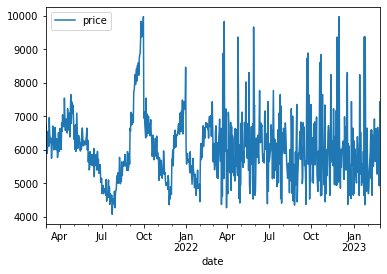

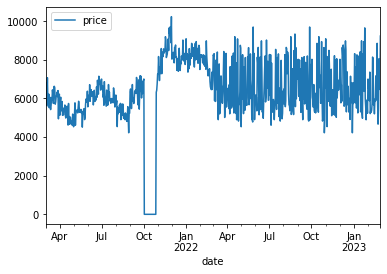

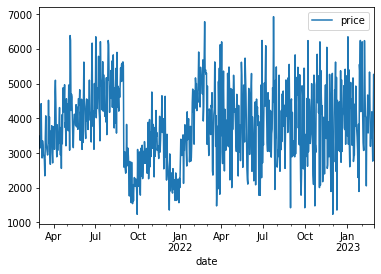

In [223]:
#On regarde les ventes par jour et par catégorie:

categ0_day = full_table[full_table["categ"] == 0].resample('D')["price"].sum().to_frame()
categ1_day = full_table[full_table["categ"] == 1].resample('D')["price"].sum().to_frame()
categ2_day = full_table[full_table["categ"] == 2].resample('D')["price"].sum().to_frame()

categ0_day.plot()

categ1_day.plot()

categ2_day.plot()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  after removing the cwd from sys.path.


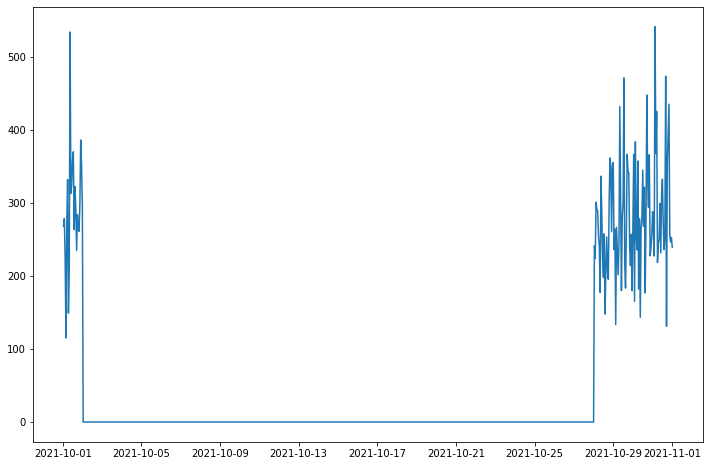

In [224]:
#On voit qu'au mois d'octobre il y a un problème avec les ventes de la catégorie 1:

#On regarde les ventes d'octobre pour la catégorie 1:
octobre = full_table["2021-10"]

categ1_oct = octobre[octobre["categ"] == 1].resample('H', label='right')["price"].sum()
plt.figure(figsize=(12,8))
plt.plot(categ1_oct)

#On voit que du 2 au 28 octobre, nous n'avons aucune données pour les ventes de la catégorie 1.
#Nous gardons quand même ces données mais en étant conscient que ce bug d'entrée des ventes aura un impact sur les analyses à venir.

## Decomposition en moyennes mobiles pour déterminer la tendance

In [225]:
#On calcule le CA mensuel pour pouvoir calculer les moyennes mobiles (notre estimation de la tendance)

CA_month = full_table.resample('M')["price"].sum().to_frame()

#On applique une moyenne mobile sur les CA mensuels pour obtenir une tendance

trend = CA_month.rolling(window=3, center=True).mean()
trend.set_index(CA_month.index)

,price
date,
2021-03-31,NaN
2021-04-30,483952.365544
2021-05-31,484493.860348
2021-06-30,486696.784366
2021-07-31,483147.801964
2021-08-31,490884.729955
2021-09-30,436884.242750
2021-10-31,448182.467015
2021-11-30,454388.445690


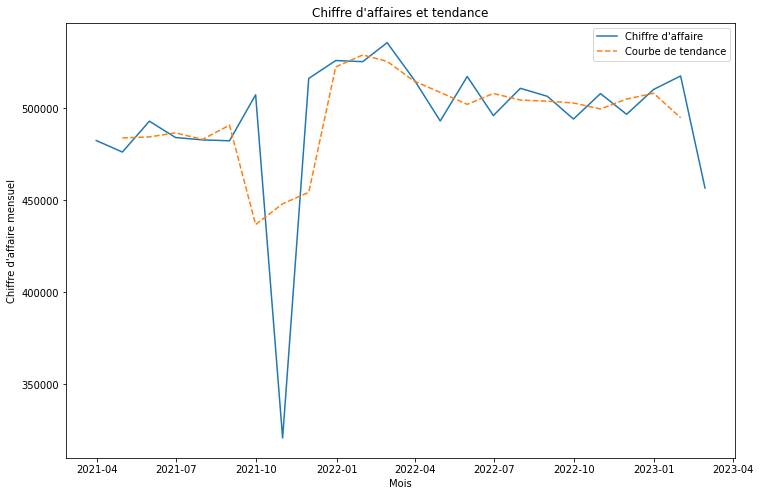

In [226]:
plt.figure(figsize=(12,8))
plt.plot(CA_month, label="Chiffre d'affaire")
plt.plot(trend, label="Courbe de tendance", ls='--')
plt.title("Chiffre d'affaires et tendance")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaire mensuel")
plt.legend()

## Décomposition complète de la série:

In [227]:
#On obtient la série détendancée en soustrayant la tendance. Il nous reste la saisonnalité et le bruit.

detrend = (CA_month - trend)
CA_month = CA_month.rename(columns={'price':'data'})

detrend['month'] = detrend.index.month

#On récupère la saisonnalité en faisant la moyenne de chaque mois de la série détendancée.

seasonnality = detrend.groupby('month')['price'].mean()
season = pd.merge(detrend, seasonnality,on='month', how='left')
season = season.rename(columns={'price_x':'detrend', 'price_y':'seasonnality'})

season = season.set_index(detrend.index)
season = season.drop(['month'], axis=1)
trend = trend.rename(columns={'price':'trend'})

In [228]:
decomposition = pd.merge(CA_month, trend, on='date', how='left')
decomposition = pd.merge(decomposition, season, on='date', how='left')

In [229]:
#Enfin on extrait le bruit en soustrayant la tendance et la saisonnalité à la série de départ.
decomposition['noise'] = decomposition['data'] - (decomposition['trend'] + decomposition['seasonnality'])

In [230]:
#On obtient ainsi le tableau reprennant toutes les composantes de la série temporelle.
decomposition

,data,trend,detrend,seasonnality,noise
date,,,,,
2021-03-31,482546.205152,NaN,NaN,769.140539,NaN
2021-04-30,476273.559125,483952.365544,-7678.806420,-11602.656077,3923.849658
2021-05-31,493037.332357,484493.860348,8543.472009,11834.936128,-3291.464119
2021-06-30,484170.689562,486696.784366,-2526.094804,-7271.003923,4744.909119
2021-07-31,482882.331179,483147.801964,-265.470786,3065.338799,-3330.809585
2021-08-31,482390.385152,490884.729955,-8494.344804,-2917.468064,-5576.876740
2021-09-30,507381.473536,436884.242750,70497.230786,30889.285393,39607.945393
2021-10-31,320880.869562,448182.467015,-127301.597452,-59474.787060,-67826.810393
2021-11-30,516285.057946,454388.445690,61896.612256,26825.473923,35071.138333


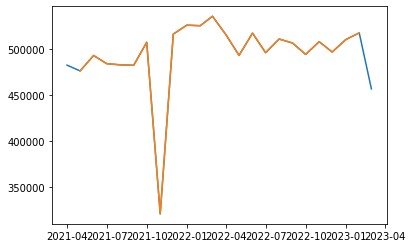

In [231]:
#On vérifie que la somme des composants correspond bien à la série initiale.
plt.plot(decomposition.data)
# plt.plot(decomposition.trend)
plt.plot((decomposition.trend + decomposition.seasonnality + decomposition.noise))

Chiffre d'affaire total :  11,856,321.63 €
catégorie 0 :  4,422,323.92 €
catégorie 1 :  4,653,722.69 €
catégorie 2 :  2,780,275.02 €


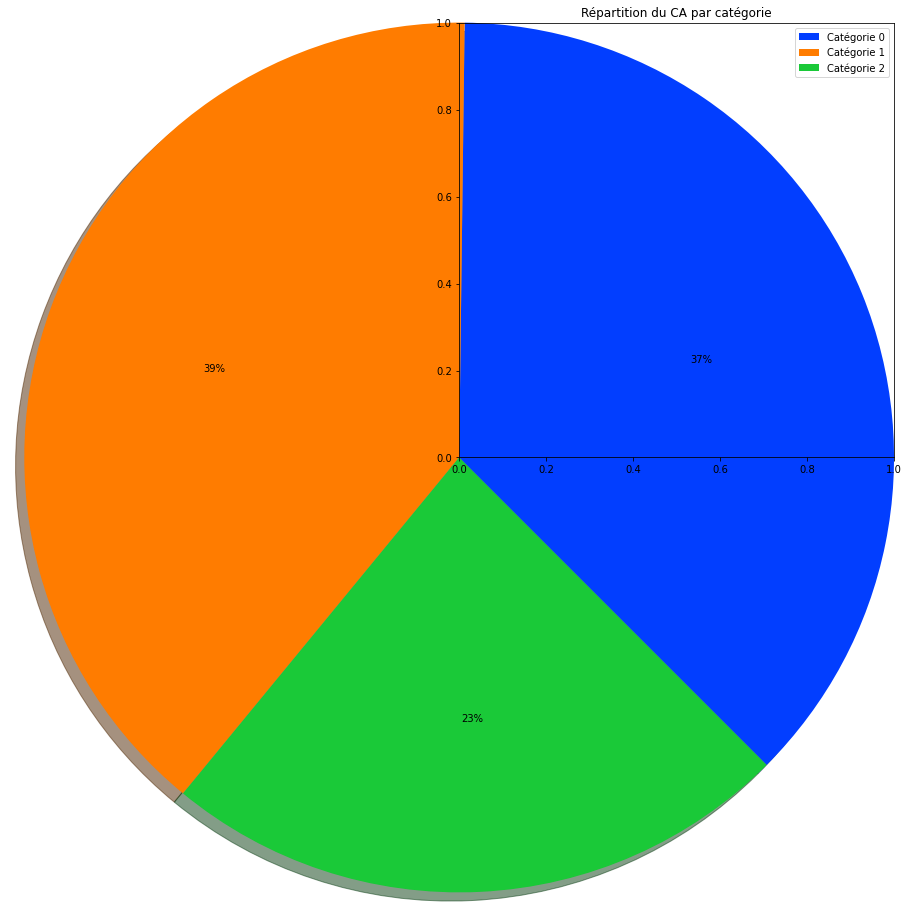

In [232]:
#On peut calculer le chiffre d'affaire
    # - total sur les 2 ans d'activité :

CA_total = full_table["price"].sum()
print("Chiffre d'affaire total : ", format(CA_total, ",.2f"), "€")
    
    
    # - par catégorie :
CA_categ0 = full_table[full_table["categ"] == 0]["price"].sum()
CA_categ1 = full_table[full_table["categ"] == 1]["price"].sum()
CA_categ2 = full_table[full_table["categ"] == 2]["price"].sum()
print("catégorie 0 : ", format(CA_categ0, ",.2f"), "€")
print("catégorie 1 : ",format(CA_categ1, ",.2f"), "€") 
print("catégorie 2 : ",format(CA_categ2, ",.2f"), "€")


colors = sns.color_palette("bright")
data = [CA_categ0, CA_categ1, CA_categ2]
labels = ["Catégorie 0", "Catégorie 1", "Catégorie 2"]

plt.figure(figsize=(12,8))
plt.pie(data,
       labels=labels,
       labeldistance=None,
       colors=colors,
       autopct = '%0.0f%%',
       startangle=-45,
       frame=True,
    #    textprops={'color':'Yellow', 'fontsize':10},
       shadow=True)
plt.title("Répartition du CA par catégorie")
plt.legend()

{'boxes': [<matplotlib.lines.Line2D at 0x7f5f0868aed0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5f086777d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5f086707d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5f08670290>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5f08471d50>,
  <matplotlib.lines.Line2D at 0x7f5f08677290>]}

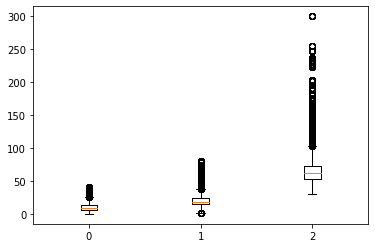

In [233]:
#On regarde la répartition des prix par catégorie pour mieux comprendre le résultat précédent:

plt.boxplot(full_table[full_table['categ'] == 0.0]['price'], positions = [0])
plt.boxplot(full_table[full_table['categ'] == 1.0]['price'], positions = [1])
plt.boxplot(full_table[full_table['categ'] == 2.0]['price'], positions = [2])

On voit ici que les prix de la catégorie 2 sont bien plus élevés que les deux autres catégories. Cela explique la prédominance de ces dernières dans le chiffre d'affaires.

sex
f    5.861056e+06
m    5.995266e+06
Name: price, dtype: float64


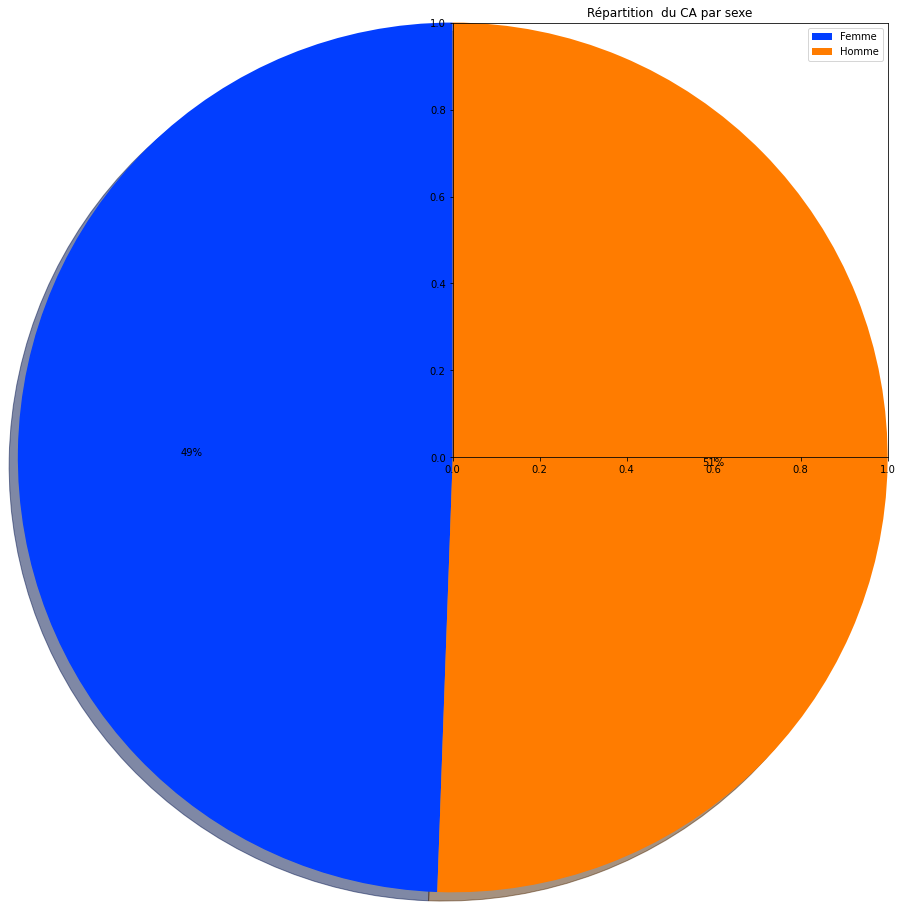

In [234]:
    # - par sexe :
print(full_table.groupby(by="sex")["price"].sum())
femme = full_table[full_table["sex"] == 'f']["price"].sum()
homme = full_table[full_table["sex"] == 'm']["price"].sum()
data=[femme, homme]
labels=["Femme", "Homme"]
plt.figure(figsize=(12,8))
plt.pie(data,
        labels=labels,
        colors=colors,
        labeldistance=None,
        autopct = '%0.0f%%',
        startangle=90,
        frame=True,
        shadow=True)
plt.title("Répartition  du CA par sexe")
plt.legend()

In [235]:
#On veut analyser les ventes en segmentant les clients en fonction de leur âge.

#On crée une colonne "age" des clients en fonction de l'année en cours.
from datetime import date
today = date.today()
full_table["age"] = today.year - full_table["birth"]


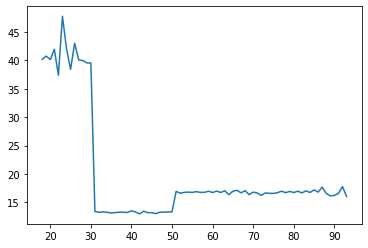

In [236]:
plt.plot(full_table.groupby("age")["price"].mean())

In [237]:
# 3 catégories se dégagent : 17-30, 31-50 et les 51+
#On crée donc une colonne "segment" qui associe une catégorie d'âge à un client, cela afin de traiter l'information en tant que variable qualitative

full_table['segment'] = pd.cut(full_table['age'], bins=[full_table['age'].min()-1, 30, 50, full_table['age'].max()], right=True, labels=["17-30", "31-50", "51 et +"])

#On peut alors afficher les ventes par segment d'age :
full_table.groupby("segment")["price"].sum()

g17_30 = full_table[full_table["segment"] == "17-30"]["price"].sum()
g31_50 = full_table[full_table["segment"] == "31-50"]["price"].sum()
g51_93 = full_table[full_table["segment"] == "51 et +"]["price"].sum()

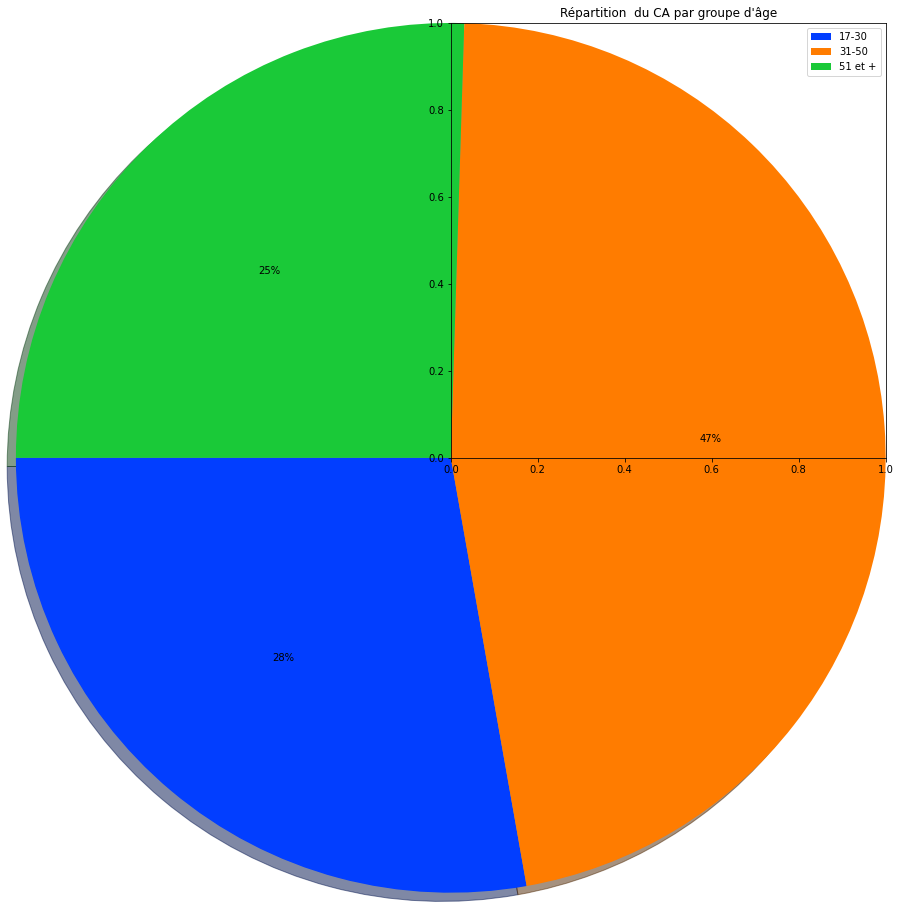

In [238]:
data=[g17_30, g31_50, g51_93]
labels=["17-30", "31-50", "51 et +"]

plt.figure(figsize=(12,8))
plt.pie(data,
        labels=labels,
        colors=colors,
        labeldistance=None,
        autopct = '%0.0f%%',
        startangle=180,
        frame=True,
        shadow=True)
plt.title("Répartition  du CA par groupe d'âge")
plt.legend()

In [239]:
#10 Livres les plus vendus :
book_first10 = full_table.groupby("id_prod")["price"].count().sort_values(ascending=False)[:10].to_frame()
book_first10.rename(columns={"price":"nombre de ventes"})

,nombre de ventes
id_prod,
1_369,2252
1_417,2189
1_414,2180
1_498,2128
1_425,2096
1_403,1960
1_412,1951
1_413,1945
1_406,1939


In [240]:
#Livres les moins vendus :

lsb = full_table.groupby("id_prod")["price"].count().reset_index()
lsb.loc[lsb['price']==1, 'id_prod']
#Tous ces livres n'ont été vendu qu'une seule fois

166     0_1151
313     0_1284
417     0_1379
549     0_1498
595     0_1539
665     0_1601
698     0_1633
752     0_1683
802     0_1728
1327    0_2201
1785     0_541
1793     0_549
2080     0_807
2109     0_833
2167     0_886
3176      2_23
3248      2_81
3264      2_98
Name: id_prod, dtype: object

In [241]:
a = round(full_table.groupby("id_prod")["price"].count().mean(),1)
b = full_table.groupby("id_prod")["price"].count().median()

print("En moyenne, on vend {0} exemplaires d'un livre. La médiane du nombre d'exemplaires uniques vendus est de {1}.".format(a, b))


En moyenne, on vend 208.0 exemplaires d'un livre. La médiane du nombre d'exemplaires uniques vendus est de 57.0.


In [242]:
montant_total_achat = full_table.groupby("client_id")["price"].sum().to_frame()
montant_total_achat = montant_total_achat.rename(columns={"price":"montant_total_achat"})

In [243]:
freq_achat = full_table.groupby("client_id")["session_id"].count().to_frame()
freq_achat = freq_achat.rename(columns={"session_id":"freq_achat"})

In [244]:
full_table = pd.merge(full_table, montant_total_achat, on="client_id", how="left")
full_table = pd.merge(full_table, freq_achat, on="client_id", how="left")

In [245]:
full_table["panier_moyen"] = full_table["montant_total_achat"]/full_table["freq_achat"]
full_table

,id_prod,session_id,client_id,sex,birth,price,categ,age,segment,montant_total_achat,freq_achat,panier_moyen
0,0_1518,s_211425,c_103,f,1986,4.18,0.0,36,31-50,2288.490000,195,11.735846
1,1_251,s_158752,c_8534,m,1988,15.99,1.0,34,31-50,3498.140000,247,14.162510
2,0_1277,s_225667,c_6714,f,1968,7.99,0.0,54,51 et +,153669.316768,9187,16.726822
3,2_209,s_52962,c_6941,m,2000,69.99,2.0,22,17-30,886.500000,17,52.147059
4,0_1509,s_325227,c_4232,m,1980,4.99,0.0,42,31-50,2381.560000,168,14.175952
...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,s_150195,c_8489,f,1951,12.99,0.0,71,51 et +,1088.840000,73,14.915616
679328,1_639,s_181434,c_4370,f,1977,10.99,1.0,45,31-50,1186.770000,84,14.128214
679329,0_1425,s_314704,c_304,f,1988,12.99,0.0,34,31-50,1692.890000,117,14.469145
679330,0_1994,s_63204,c_2227,m,1986,4.98,0.0,36,31-50,3056.290000,234,13.061068


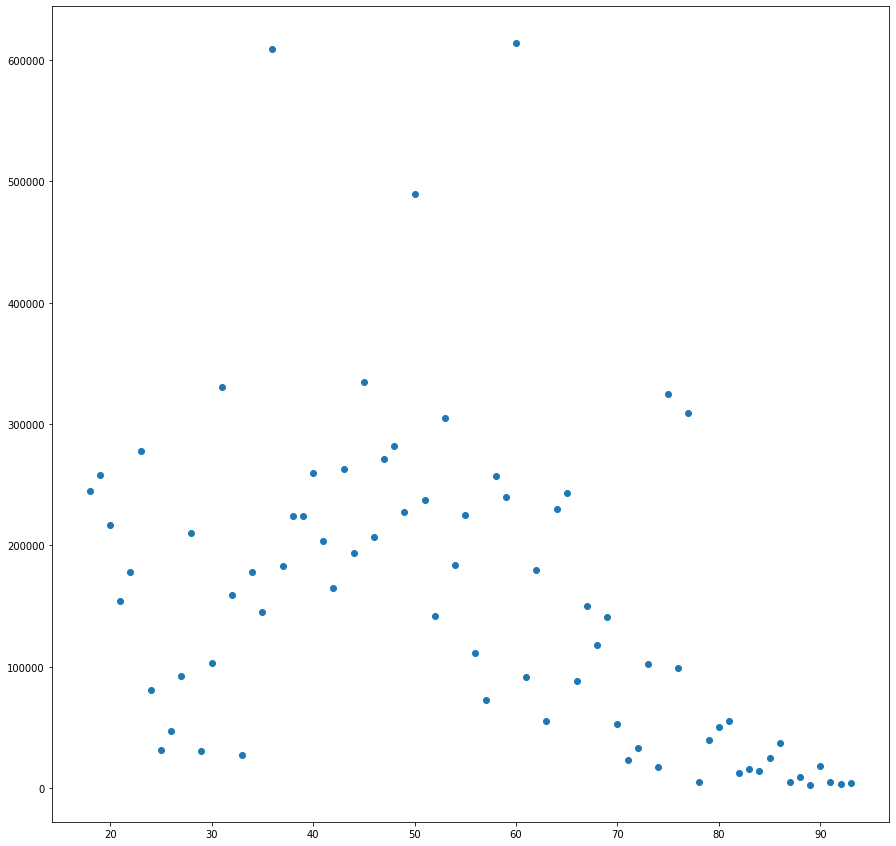

In [246]:
# On peut regarder la répartition des âges dans les ventes :

x = full_table['age'].unique()

y = full_table.groupby('age')['price'].sum()

plt.figure(figsize=(15,15))
plt.scatter(x, y)

On voit sur le nuage de point ci-dessus que le CA/age est plus élevé pour les âges du segment 31-50 ans.

In [247]:
#On veut calculer le coef de Gini et la courbe de Lorenz de la répartion des ventes
# - par clients:
client = full_table.groupby(by="client_id")["price"].sum().sort_values(ascending=True).to_numpy()
# - par livres:
livre = full_table.groupby(by="id_prod")["price"].sum().sort_values(ascending=True).to_numpy()

In [248]:
#Coefficient de Gini

def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

print("coef Gini pour les clients : ", gini(client))
print("coef Gini pour les livres : ", gini(livre))

coef Gini pour les clients :  0.4463965884675667
coef Gini pour les livres :  0.7428265830646286


None
None


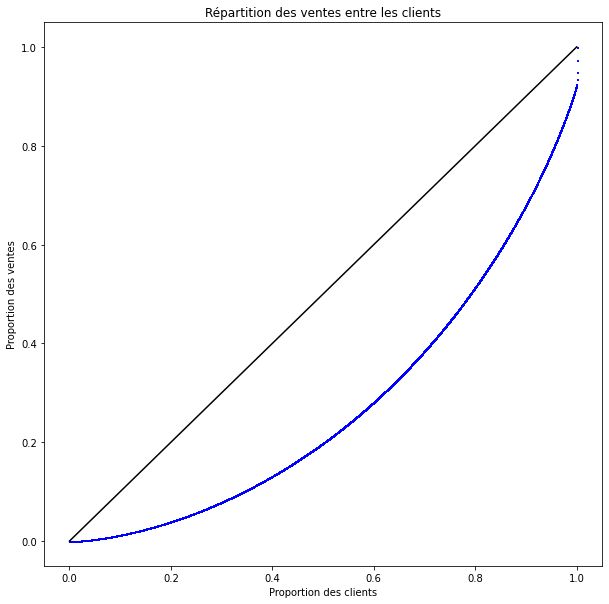

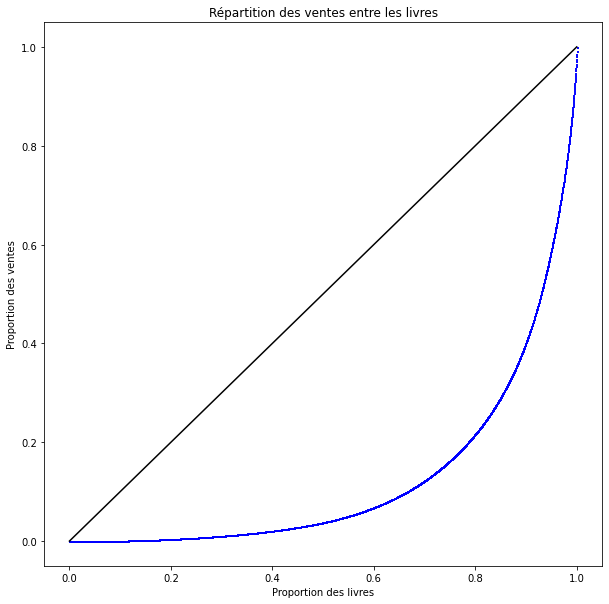

In [249]:
#Courbe de Lorenz

def lorenz_curve(X, label):
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[10,10])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='s', color='blue', s=1)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')
    title = "Répartition des ventes entre les " + label
    ax.set_title(title)
    ax.set_ylabel("Proportion des ventes")
    xlabel = "Proportion des " + label
    ax.set_xlabel(xlabel)

print(lorenz_curve(client, "clients"))
print(lorenz_curve(livre, "livres"))

### On voit sur la 2e courbe de Lorenz un effet Pareto pour les livres : environ 20% des livres permettent la réalisation d'environ 80% du chiffre d'affaire.

# TESTS

In [250]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   id_prod              679332 non-null  object  
 1   session_id           679332 non-null  object  
 2   client_id            679332 non-null  object  
 3   sex                  679332 non-null  object  
 4   birth                679332 non-null  int64   
 5   price                679332 non-null  float64 
 6   categ                679332 non-null  float64 
 7   age                  679332 non-null  int64   
 8   segment              679332 non-null  category
 9   montant_total_achat  679332 non-null  float64 
 10  freq_achat           679332 non-null  int64   
 11  panier_moyen         679332 non-null  float64 
dtypes: category(1), float64(4), int64(3), object(4)
memory usage: 62.8+ MB


In [251]:
# On trie nos colonnes pour déterminer les tests en fonction du type de variable.

num_list = []
cat_list = []

for column in full_table:
    if is_numeric_dtype(full_table[column]):
        num_list.append(column)
    elif is_string_dtype(full_table[column]):
        cat_list.append(column)
    else:
        cat_list.append(column)
print("numérique: ", num_list)
print("catégorique : ", cat_list)

numérique:  ['birth', 'price', 'categ', 'age', 'montant_total_achat', 'freq_achat', 'panier_moyen']
catégorique :  ['id_prod', 'session_id', 'client_id', 'sex', 'segment']


## Test CHI² entre genre et catégorie achetée

Un test Chi² est utilisé pour comparer des variables catégoriques entre-elles.

In [252]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [253]:
contingency_table = pd.crosstab(full_table.sex, full_table.categ)
print(contingency_table)

categ     0.0     1.0    2.0
sex                         
f      206220  114899  17283
m      209460  112270  19200


H0 : pas de lien entre genre et catégorie achetée

Ha : on rejette H0

In [254]:
significance_level = 0.05

c, p, dof, expected = chi2_contingency(contingency_table)
print(p)
if p <= significance_level: 
    print('On rejette H0, on ne peut pas prouver qu\'il n\'y a pas de lien entre les deux variables') 
else: 
    print('On accepte H0, il n\'y a pas de lien entre les deux variables')

1.1989607410166063e-32
On rejette H0, on ne peut pas prouver qu'il n'y a pas de lien entre les deux variables


## Test CHI² entre age et catégorie achetée

In [255]:
contingency_table = pd.crosstab(full_table.segment, full_table.categ)
print(contingency_table)

categ       0.0    1.0    2.0
segment                      
17-30     16701  29975  33182
31-50    319591  98121   1486
51 et +   79388  99073   1815


H0 : pas de lien entre groupe d'âge et catégorie achetée

Ha : on rejette H0

In [256]:
significance_level = 0.05

c, p, dof, expected = chi2_contingency(contingency_table)
print(p)
if p <= significance_level: 
    print('On rejette H0, on ne peut pas prouver qu\'il n\'y a pas de lien entre les deux variables') 
else: 
    print('On accepte H0, il n\'y a pas de lien entre les deux variables')

0.0
On rejette H0, on ne peut pas prouver qu'il n'y a pas de lien entre les deux variables


## Test correlation Pearson entre l'age (num) et la frequence d'achat
La correlation de Pearson compare 2 variables numériques

In [257]:
age = full_table["age"]
freq = full_table["freq_achat"]

from scipy.stats import pearsonr
corr, _ = pearsonr(age, freq)

print(corr)

-0.018608958104244608


La correlation est proche de 0, on peut donc dire qu'il n'y a pas de lien entre l'âge des clients et la fréquence de leurs achats.

## Test de normalité : Kolmogorov-Smirnov

In [258]:
# Pour pouvoir utiliser les test ANOVA, il faut vérifier que les valeurs de nos variables sont normalement distribuées. Pour cela nous utilisons un test de kolmogorov-smirnov.
from numpy.random import normal
from scipy.stats import kstest

H0 = 'La distribution est normale.'
Ha = 'On ne peut pas dire que la distribution est normale.'

def KS_test(data):
    data = data.to_numpy()
    k = kstest(data, 'norm')
    if k.pvalue < 0.05:
        print(Ha)
    else:
        print(H0)

for variable in num_list:
    print(variable)
    KS_test(full_table[variable])
    



birth
On ne peut pas dire que la distribution est normale.
price
On ne peut pas dire que la distribution est normale.
categ
On ne peut pas dire que la distribution est normale.
age
On ne peut pas dire que la distribution est normale.
montant_total_achat
On ne peut pas dire que la distribution est normale.
freq_achat
On ne peut pas dire que la distribution est normale.
panier_moyen
On ne peut pas dire que la distribution est normale.


## Test de Kruskal-Wallis

Les valeurs ne suivent pas une distribution normale, nous allons devoir utiliser l'équivalent non paramétrique de l'ANOVA : le test de Kruskal-Wallis

### Test entre les montants totaux des achats des clients, en fonction des groupes d'âge auxquels ils appartiennent.

In [259]:
from scipy import stats

full_table["segment"] = full_table["segment"].astype(str)
full_table["segment"].unique()


H0 = "Les médianes des 3 groupes sont identiques."

Ha = "Les médianes des 3 groupes ne sont pas identiques, il y a sûrement un lien entre le groupe d\'âge et la variable comparée."
group1 = full_table[full_table["segment"] == "17-30"]["montant_total_achat"]
group2 = full_table[full_table["segment"] == "31-50"]["montant_total_achat"]
group3 = full_table[full_table["segment"] == "51 et +"]["montant_total_achat"]

a = stats.kruskal(group1, group2, group3)
print("P Value :",a.pvalue)
if a.pvalue < 0.05:
    print(Ha)
else:
    print(H0)

P Value : 0.0
Les médianes des 3 groupes ne sont pas identiques, il y a sûrement un lien entre le groupe d'âge et la variable comparée.


### Test entre la fréquence des achats des clients, en fonction des groupes d'âge auxquels ils appartiennent.

In [260]:
group1 = full_table[full_table["segment"] == "17-30"]["freq_achat"]
group2 = full_table[full_table["segment"] == "31-50"]["freq_achat"]
group3 = full_table[full_table["segment"] == "51 et +"]["freq_achat"]

a = stats.kruskal(group1, group2, group3)
print("P Value :",a.pvalue)
if a.pvalue < 0.05:
    print(Ha)
else:
    print(H0)

P Value : 0.0
Les médianes des 3 groupes ne sont pas identiques, il y a sûrement un lien entre le groupe d'âge et la variable comparée.


### Test entre le montant du panier moyen des clients, en fonction des groupes d'âge auxquels ils appartiennent.

In [261]:
group1 = full_table[full_table["segment"] == "17-30"]["panier_moyen"]
group2 = full_table[full_table["segment"] == "31-50"]["panier_moyen"]
group3 = full_table[full_table["segment"] == "51 et +"]["panier_moyen"]

a = stats.kruskal(group1, group2, group3)
print("P Value :",a.pvalue)
if a.pvalue < 0.05:
    print(Ha)
else:
    print(H0)

P Value : 0.0
Les médianes des 3 groupes ne sont pas identiques, il y a sûrement un lien entre le groupe d'âge et la variable comparée.
